c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
R-squared: 0.8537222356888796, MAE: 0.02905954135206386, RMSE: 0.03771016930371395


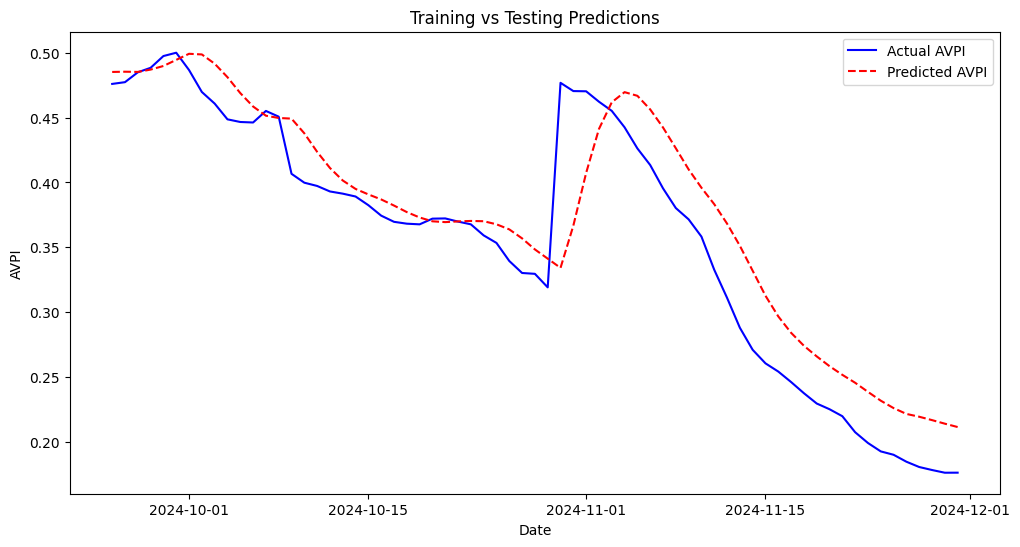

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import yaml
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

SEED = config['general']['seed']
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

file_path = config['avpi']['data']['historical_data_path']
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['AVPI']])

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = config['avpi']['sequence']['seq_length']
X, y = create_sequences(data_scaled, seq_length)

split = int(config['avpi']['split_ratio']['train_test_split_ratio'] * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

def create_lstm_model():
    model = Sequential([
        LSTM(config['avpi']['model']['lstm_units'], return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(config['avpi']['model']['dropout_rate']),
        LSTM(config['avpi']['model']['lstm_units'], return_sequences=False),
        Dropout(config['avpi']['model']['dropout_rate']),
        Dense(config['avpi']['model']['dense_units'], activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=config['avpi']['model']['optimizer'], 
                  loss=config['avpi']['model']['loss_function'])
    return model

model = create_lstm_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=config['avpi']['model']['epochs'],
                    batch_size=config['avpi']['model']['batch_size'],
                    verbose=0)

y_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
print(f"R-squared: {r2}, MAE: {mae}, RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(df.index[split+seq_length:], y_test_actual, label='Actual AVPI', color='blue')
plt.plot(df.index[split+seq_length:], y_pred_actual, label='Predicted AVPI', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('AVPI')
plt.legend()
plt.title('Training vs Testing Predictions')
plt.show()

future_dates = pd.date_range(start=config['avpi']['forecast']['forecast_start_date'], 
                             end=config['avpi']['forecast']['forecast_end_date'])
future_preds = []
last_sequence = data_scaled[-seq_length:].reshape(1, seq_length, 1)

for _ in range(len(future_dates)):
    pred = model.predict(last_sequence)[0]
    future_preds.append(pred)
    last_sequence = np.append(last_sequence[:, 1:, :],
                              [[pred + np.random.normal(0, config['avpi']['forecast']['fluctuation_factor'])]],
                              axis=1)

future_preds_actual = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

future_df = pd.DataFrame({'Date': future_dates, 'Predicted_AVPI': future_preds_actual.flatten()})
future_df.to_csv(config['avpi']['data']['prediction_output_path'], index=False)
